<a href="https://colab.research.google.com/github/Abdoul1996/Alzheimer_Classification/blob/main/Abdoul_ProjectCSC871.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import os
from pydicom import dcmread
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from skimage.color import gray2rgb
from sklearn.utils import shuffle
from skimage.transform import resize
import warnings


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models, transforms
from torch.utils.data import TensorDataset, DataLoader


warnings.filterwarnings('ignore')


tf.config.run_functions_eagerly(True)

print(tf.__version__)

2.17.1


In [2]:
%%capture
!pip install pydicom

In [3]:
%%capture
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v0.41.12/gcsfuse_0.41.12_amd64.deb; \
    dpkg --install gcsfuse_0.41.12_amd64.deb; \
    apt-get update; \
    apt-get clean;

In [4]:
from google.colab import auth
auth.authenticate_user()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:

project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Are you sure you wish to set property [core/project] to sfsu-378805?

Do you want to continue (Y/n)?  Y

Updated property [core/project].


In [32]:
!gsutil ls

You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


In [33]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [9]:
!gcsfuse --implicit-dirs csc-509-image-files images

2024/12/10 16:55:52.705728 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/images
2024/12/10 16:55:52.723434 Opening GCS connection...
2024/12/10 16:55:54.226342 Mounting file system "csc-509-image-files"...
2024/12/10 16:55:54.227213 File system has been successfully mounted.


Step 2 : Now Let's create the training, validation, testing

In [10]:
file_path = '/content/images/Module2_ADNI/CSVS/ADNI_AMYPet_withClinicalData_01122023.csv'
data_df = pd.read_csv(file_path)

In [11]:
data_df['SLICE_NUM'].unique()

array([48, 27,  5, 26, 43, 47, 42, 39, 38, 44, 15, 21,  3, 32, 35, 37, 25,
       36, 45, 40])

In [12]:
data_df['SLICE_NUM'].value_counts()

,count
SLICE_NUM,
48,445
47,20
26,16
39,16
5,12
44,12
32,12
3,8
36,8


In [13]:
# Let's get the folderpath from the middle slice filepaths.
data_df['FOLDERPATH_MIDDLE_SLICES'] = data_df['FILEPATH_MIDDLE_SLICES'].str.rsplit('/', n = 1).str[0]

In [14]:
# We will train a binary classifier for CN v/s AD, so let's filter for these values of the column Group.
data_df = data_df[['Image Data ID', 'FILEPATH_MIDDLE_SLICES', 'FOLDERPATH_MIDDLE_SLICES', 'Group' ]]
data_df_filt= data_df[data_df['Group'].isin(['AD', 'CN', 'EMCI'])].reset_index(drop = True)

In [15]:
data_df_filt.head()

,Image Data ID,FILEPATH_MIDDLE_SLICES,FOLDERPATH_MIDDLE_SLICES,Group
0,I285198,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,EMCI
1,I285200,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,EMCI
2,I285197,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,EMCI
3,I285199,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,EMCI
4,I272168,images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...,images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...,CN


In [16]:
len(data_df_filt)

437

In [17]:
data_df_filt['Group'].value_counts()

,count
Group,
EMCI,189
CN,184
AD,64


In [18]:
# Split into training, validation set and test set
ids = data_df_filt['Image Data ID'].unique()

# Here we have selected the size of test set as 15 %
train_ids, test_ids = train_test_split(ids,test_size=0.15)

# Create validation ids by further splitting the train ids, we again use 15 % as size of validation set. Validation set is also referred to as tuning set.
train_ids, val_ids = train_test_split(train_ids,test_size=0.15)


In [19]:
# Let's check the number of patients ids in train, validation and test set
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 315 patient ids in training set
There are 56 patient ids in validation set
There are 66 patient ids in test set


In [20]:
# Let's check the number of CN,AD, EMCI patients in the splits. We want our splits to be balanced.
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(train_ids), 'Train', '')
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(val_ids), 'Validation', data_df_filt['Split'])
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(test_ids), 'Test', data_df_filt['Split'])

data_df_filt[['Image Data ID', 'Group', 'Split']].groupby(by = ['Split', 'Group']).count()

Image Data ID
Split      Group               
Test       AD                12
           CN                26
           EMCI              28
Train      AD                45
           CN               133
           EMCI             137
Validation AD                 7
           CN                25
           EMCI              24

In [21]:
# Let's create a function to normalize the image between 0 and 1 and change label to 0 and 1
def normalize(image, label, percentile = 0.001,
              eps = 0.0000001):


    img_array = np.ndarray.flatten(image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    input_image = torch.tensor(img_normalized, dtype=torch.float32)/255

    if label == 'CN':
      input_label = 0
    elif label == 'EMCI':
      input_label = 1
    elif label == 'AD':
        input_label = 2
    else:
        raise ValueError(f"Unexpected label: {label}")


    return input_image, input_label

In [22]:
# Let's create a function read dicoms and sort by slice number

def read_all_dicom_slices(dicom_directory):
    """
    Will read in the images from a single dicom folder and return a dictionary of
    those images with the key as the presumed slice number, and the value being the pixel array.

    dicom_directory: Path or string that leads to the folder containing the slices

    """
    dicom_image_dict = {}
    for image in glob.glob(str(Path(dicom_directory, '*'))):
      key = image.split('/')[-1].split('_')[-3]
      dicom_image_dict[key]= pydicom.dcmread(image)
    return dicom_image_dict

In [23]:
'''import pydicom
def select_middle_slice(foldername):
    """
    Selects the middle slice from a folder of DICOM files.
    """
    # Find all DICOM files in the folder
    dicom_files = glob.glob(foldername + "/*.dcm")

    if not dicom_files:
        raise FileNotFoundError(f"No DICOM files found in folder: {foldername}")

    # Read DICOM files and filter valid ones
    slices = []
    for file in dicom_files:
        try:
            dicom = pydicom.dcmread(file)  # Use dcmread instead of read_file
            if hasattr(dicom, 'SliceLocation'):
                slices.append(dicom)
        except Exception as e:
            print(f"Error reading file {file}: {e}")

    if not slices:
        raise ValueError(f"No valid slices found in folder: {foldername}")

    # Sort slices by SliceLocation
    slices.sort(key=lambda x: float(x.SliceLocation))

    # Select the middle slice
    middle_slice = slices[len(slices) // 2]

    # Get the pixel array of the middle slice
    image = middle_slice.pixel_array

    # Convert the grayscale image to RGB
    return gray2rgb(image)'''


'import pydicom\ndef select_middle_slice(foldername):\n    """\n    Selects the middle slice from a folder of DICOM files.\n    """\n    # Find all DICOM files in the folder\n    dicom_files = glob.glob(foldername + "/*.dcm")\n\n    if not dicom_files:\n        raise FileNotFoundError(f"No DICOM files found in folder: {foldername}")\n\n    # Read DICOM files and filter valid ones\n    slices = []\n    for file in dicom_files:\n        try:\n            dicom = pydicom.dcmread(file)  # Use dcmread instead of read_file\n            if hasattr(dicom, \'SliceLocation\'):\n                slices.append(dicom)\n        except Exception as e:\n            print(f"Error reading file {file}: {e}")\n\n    if not slices:\n        raise ValueError(f"No valid slices found in folder: {foldername}")\n\n    # Sort slices by SliceLocation\n    slices.sort(key=lambda x: float(x.SliceLocation))\n\n    # Select the middle slice\n    middle_slice = slices[len(slices) // 2]\n\n    # Get the pixel array of t

In [24]:
from tqdm import tqdm
import logging
import numpy as np

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

def create_numpy_array(df):
    X = []
    Y = []
    for i in tqdm(range(len(df)), desc="Processing DataFrame"):
        logging.info(f"Processing row {i+1}/{len(df)}: {df['FOLDERPATH_MIDDLE_SLICES'][i]}")
        dicom_volume = read_all_dicom_slices(df['FOLDERPATH_MIDDLE_SLICES'][i])
        keys_sorted = [str(x) for x in sorted([int(x) for x in list(dicom_volume.keys())])]
        keys_filt = [45, 47, 48, 49, 50]

        for key in keys_filt:
            value = dicom_volume.get(str(key), None)
            if value:
                image = value.pixel_array
                label = df['Group'][i]
                new_image, new_label = normalize(image, label)
                X.append(new_image)
                Y.append(new_label)

    return np.asarray(X), np.asarray(Y)

In [25]:
data_df_filt.head()

,Image Data ID,FILEPATH_MIDDLE_SLICES,FOLDERPATH_MIDDLE_SLICES,Group,Split
0,I285198,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,EMCI,Train
1,I285200,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,EMCI,Train
2,I285197,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,EMCI,Train
3,I285199,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...,EMCI,Train
4,I272168,images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...,images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...,CN,Train


In [26]:
# Split into training, validation set and test set
ids = data_df_filt['Image Data ID'].unique()

# Here we have selected the size of test set as 15 %
train_ids, test_ids = train_test_split(ids,test_size=0.15)

# Create validation ids by further splitting the train ids, we again use 15 % as size of validation set. Validation set is also referred to as tuning set.
train_ids, val_ids = train_test_split(train_ids,test_size=0.15)


In [27]:
# Let's check the number of patients ids in train, validation and test set
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 315 patient ids in training set
There are 56 patient ids in validation set
There are 66 patient ids in test set


In [28]:
# Let's check the number of CN and AD patients in the splits. We want our splits to be balanced.
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(train_ids), 'Train', '')
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(val_ids), 'Validation', data_df_filt['Split'])
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(test_ids), 'Test', data_df_filt['Split'])

data_df_filt[['Image Data ID', 'Group', 'Split']].groupby(by = ['Split', 'Group']).count()


Image Data ID
Split      Group               
Test       AD                 9
           CN                27
           EMCI              30
Train      AD                43
           CN               135
           EMCI             137
Validation AD                12
           CN                22
           EMCI              22

In [29]:
# Let's create numpy arrays for training, validation and test sets using the above 3 functions
#X_train, Y_train = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Train'].reset_index(drop = True))
#X_val, Y_val = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Validation'].reset_index(drop = True))
#X_test, Y_test = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Test'].reset_index(drop = True))

In [30]:
'''%cd /content/drive/MyDrive
!mkdir data_stored'''


'%cd /content/drive/MyDrive\n!mkdir data_stored'

In [31]:
# Let's save the train, validation and test arrays to a path in your drive
#np.save('/content/drive/MyDrive/data_stored/AmyPET_train_images.npy', X_train) # Enter the path where you will save the file
#np.save('/content/drive/MyDrive/data_stored/AmyPET_val_images.npy', X_val)
#np.save('/content/drive/MyDrive/data_stored/AmyPET_test_images.npy', X_test)
#np.save('/content/drive/MyDrive/data_stored/AmyPET_train_label.npy', Y_train)
#np.save('/content/drive/MyDrive/data_stored/AmyPET_val_label.npy', Y_val)
#np.save('/content/drive/MyDrive/data_stored/AmyPET_test_label.npy', Y_test)

In [12]:
# Let's load train, validation, test arrays
X_train = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_train_images.npy')
Y_train = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_train_label.npy')
X_val = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_val_images.npy')
Y_val = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_val_label.npy')
X_test = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_test_images.npy')
Y_test = np.load('/content/drive/MyDrive/Numpy2_ADNi/AmyPET_test_label.npy')

In [13]:
# prompt: print the length and shape X AND Y train, val, and test

print("X_train length:", len(X_train))
print("X_train shape:", X_train.shape)
print("Y_train length:", len(Y_train))
print("Y_train shape:", Y_train.shape)

print("X_val length:", len(X_val))
print("X_val shape:", X_val.shape)
print("Y_val length:", len(Y_val))
print("Y_val shape:", Y_val.shape)

print("X_test length:", len(X_test))
print("X_test shape:", X_test.shape)
print("Y_test length:", len(Y_test))
print("Y_test shape:", Y_test.shape)

X_train length: 1200
X_train shape: (1200, 160, 160)
Y_train length: 1200
Y_train shape: (1200,)
X_val length: 215
X_val shape: (215, 160, 160)
Y_val length: 215
Y_val shape: (215,)
X_test length: 250
X_test shape: (250, 160, 160)
Y_test length: 250
Y_test shape: (250,)


In [14]:
# Converting grayscale images to RGB
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [15]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 1200 images in training set
There are 215 images in validation set
There are 250 images in test set


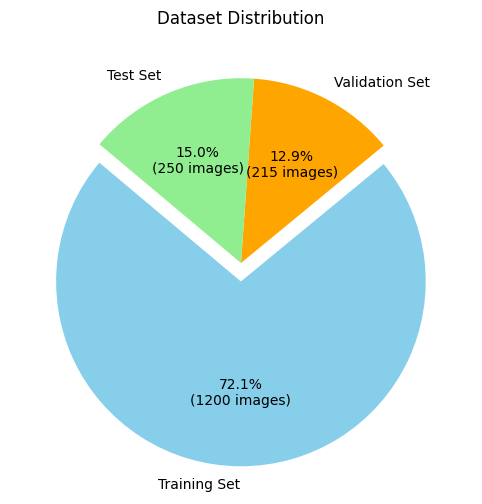

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the dataset split is done and X_train, X_val, and X_test are created
# Calculate the sizes dynamically
sizes = [len(X_train), len(X_val), len(X_test)]  # Number of images in each set
labels = ['Training Set', 'Validation Set', 'Test Set']  # Labels for the sets
colors = ['skyblue', 'orange', 'lightgreen']  # Colors for the pie chart
explode = (0.1, 0, 0)  # Highlight the training set for better emphasis

# Custom function to format labels with percentage and count
def format_labels(pct, all_vals):
    absolute = int(round(pct / 100. * np.sum(all_vals)))
    return f'{pct:.1f}%\n({absolute} images)'

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: format_labels(pct, sizes),
        startangle=140, explode=explode)
plt.title('Dataset Distribution')
plt.show()


In [78]:
# prompt: X_train I want to know if the data is balanced how can i check

from collections import Counter

# Count the occurrences of each class label in Y_train
class_counts = Counter(Y_train)

# Print the class distribution
print("Class Distribution in Y_train:")
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} samples ({count / len(Y_train) * 100:.2f}%)")

# Check for class imbalance (you can define a threshold for imbalance)
imbalance_threshold = 0.2  # Example: 20% difference between the largest and smallest class
if max(class_counts.values()) / min(class_counts.values()) > (1 + imbalance_threshold):
  print("\nWARNING: Class imbalance detected in Y_train")
else:
  print("\nClass distribution appears relatively balanced.")

Class Distribution in Y_train:
Class 1: 505 samples (42.08%)
Class 0: 460 samples (38.33%)
Class 2: 235 samples (19.58%)



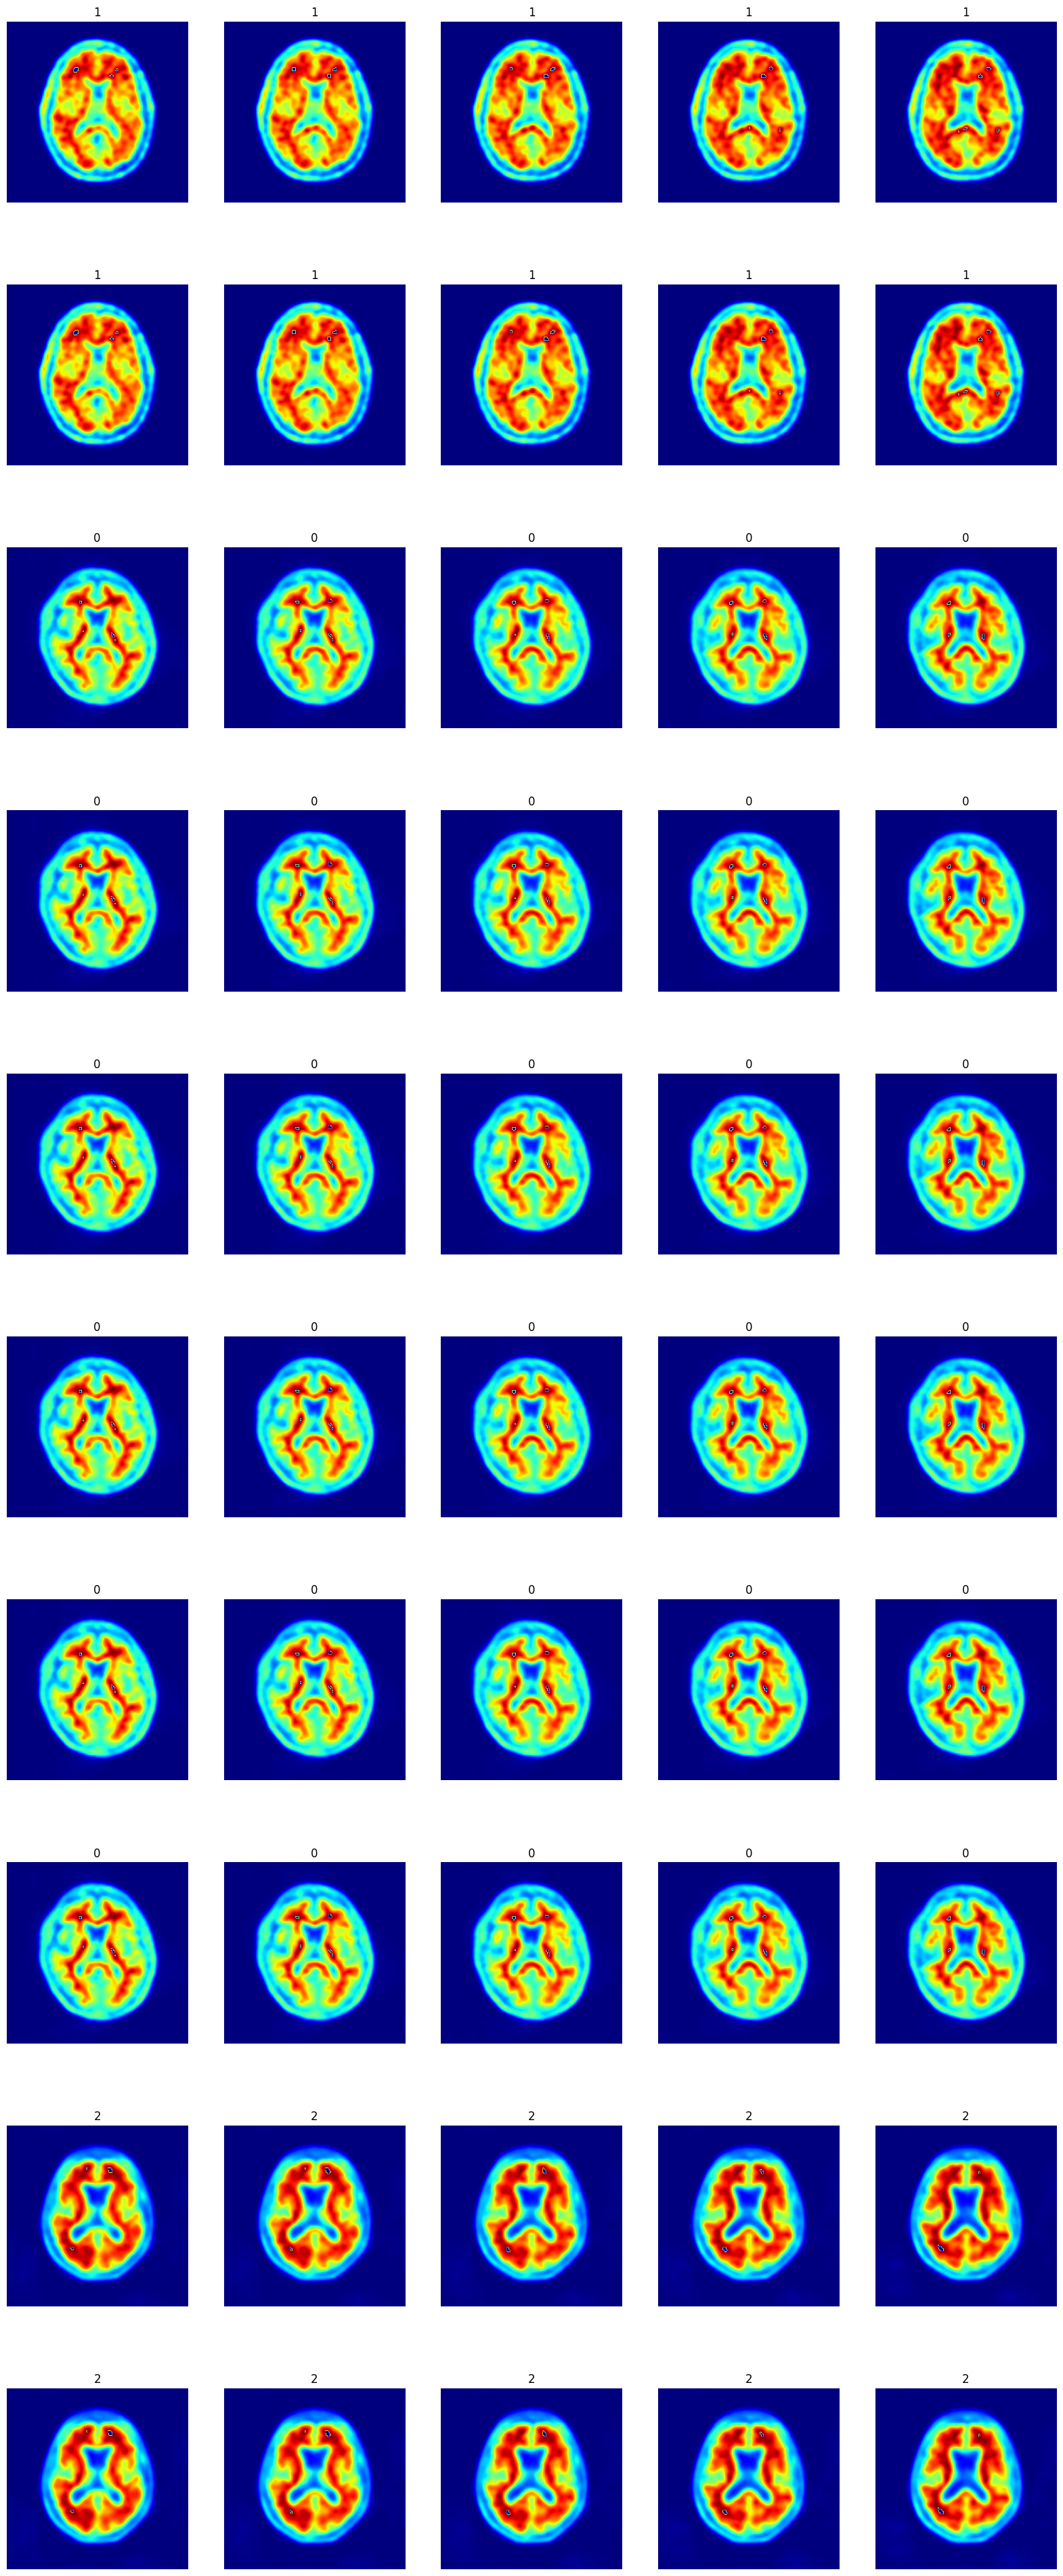

In [17]:
# Let's look at some of the PET images of CN, EMCI and AD patients
plt.figure(figsize = (20, 100))
for i in range(50):

    plt.subplot(20,5, i+1)
    plt.imshow(X_train[i][:,:,0], cmap = 'jet')
    plt.axis('off')
    plt.title(Y_train[i])

In [34]:
# Convert NumPy arrays to PyTorch tensors with channel-first format
X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, C, H, W)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, C, H, W)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)  # (N, C, H, W)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)


In [35]:
X_train_tensor.shape

torch.Size([1200, 3, 160, 160])

### Data Augmentation

In [45]:
from torchvision import transforms

data_augmentation_resNet50 = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize first for consistent input size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image within a range of 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Random affine transformations
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Correct normalization
])


### Create a Custom Dataset Class

In [46]:

from torch.utils.data import Dataset
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


### Creation Dataset

In [47]:
# Training Dataset with Augmentation
dataset_train = AugmentedDataset(
    X_train_tensor,
    Y_train_tensor,
    transform=data_augmentation_resNet50
)
# Validation Dataset with Preprocessing Only (No Augmentation)
dataset_val = AugmentedDataset(
    X_val_tensor,
    Y_val_tensor,
    transform=transforms.Compose([
        transforms.Resize((299, 299)),  # Resize to match training input size
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Correct normalization
    ])
)

# Normalize directly since X_test_tensor is already a tensor
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)  # Match tensor shape
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

# Resize tensor and normalize
X_test_resized = torch.nn.functional.interpolate(X_test_tensor, size=(299, 299), mode='bilinear', align_corners=False)
X_test_normalized = (X_test_resized - mean) / std

# Create test dataset
dataset_test = TensorDataset(X_test_normalized, Y_test_tensor)
'''# Test Dataset with Preprocessing Only (No Augmentation)
dataset_test = TensorDataset(
    transforms.Resize((299, 299))(X_test_tensor),  # Resize
    transforms.ToTensor()(Y_test_tensor),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Correct normalization
)'''

'# Test Dataset with Preprocessing Only (No Augmentation)\ndataset_test = TensorDataset(\n    transforms.Resize((299, 299))(X_test_tensor),  # Resize\n    transforms.ToTensor()(Y_test_tensor),  # Convert to PyTorch tensor\n    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Correct normalization\n)'

### DataLoader Creation

In [48]:
from torch.utils.data import DataLoader

batch_size = 32
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

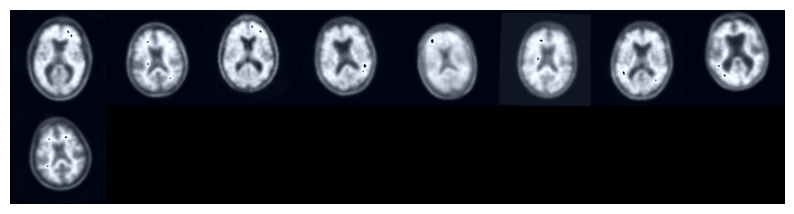

In [49]:
import matplotlib.pyplot as plt
import torchvision

for images, labels in dataloader_train:
    # Unnormalize the images (if normalization was applied)
    mean = torch.tensor([0.485, 0.485, 0.485]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.229, 0.229]).view(1, 3, 1, 1)
    images = images * std + mean  # Reverse normalization

    # Create a grid of images
    grid = torchvision.utils.make_grid(images[:9])  # First 9 images

    # Plot the images
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))  # Transpose dimensions (C, H, W) -> (H, W, C)
    plt.axis('off')
    plt.show()
    break  # Display one batch only


### Load Pretrained model



In [51]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet50Classifier, self).__init__()
        self.base_model = models.resnet50(pretrained=True)

        # Freeze all layers except the final block
        for name, param in self.base_model.named_parameters():
            if "layer4" in name:  # Unfreeze only the final residual block
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Replace the fully connected layer with a custom classifier
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.6),               # Increased dropout for regularization
            nn.Linear(num_features, 512),  # Fully connected layer
            nn.ReLU(),                     # Activation
            nn.Dropout(0.6),               # Increased dropout for regularization
            nn.Linear(512, num_classes)    # Final output layer
        )

    def forward(self, x):
        """
        Forward pass for the model.
        :param x: Input tensor.
        :return: Output logits.
        """
        return self.base_model(x)


### Replace the final fully connected layer

In [52]:
num_classes = 3
restNet50_model = ResNet50Classifier(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
restNet50_model= restNet50_model.to(device)


### Setting up Loss, optimizer and scheduler

In [28]:
import torch.optim as optim
# Higher initial learning rate
optimizer = optim.Adam([
        {'params': restNet50_model.base_model.fc.parameters(), 'lr': 1e-3},
        {'params': (p for n, p in restNet50_model.base_model.named_parameters() if 'fc' not in n and p.requires_grad), 'lr': 1e-4}
    ])

In [29]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

### Early Stopped

In [54]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pth', verbose=True):
        """
        Early stopping to stop training when validation loss stops improving.

        :param patience: How many epochs to wait after the last improvement.
        :param delta: Minimum change in validation loss to qualify as improvement.
        :param path: Path to save the best model.
        :param verbose: Whether to print updates.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        """
        Check if training should be stopped early.
        :param val_loss: Current validation loss.
        :param model: Current model.
        """
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """Save the current best model."""
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f"Validation loss decreased. Saving model to {self.path}")


### Train Phase

### Training Model

In [56]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda', patience=5):
    """
    Train and validate a model with early stopping.

    :param model: PyTorch model
    :param train_loader: DataLoader for training data
    :param val_loader: DataLoader for validation data
    :param criterion: Loss function
    :param optimizer: Optimizer
    :param scheduler: Learning rate scheduler
    :param num_epochs: Number of training epochs
    :param device: Device to train on ('cuda' or 'cpu')
    :param patience: Patience for early stopping
    :return: Training and validation history
    """
    model = model.to(device)
    early_stopping = EarlyStopping(patience=patience, path='best_model.pth')

    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * correct / total
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Learning rate scheduling
        scheduler.step(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

        # Early stopping
        early_stopping(epoch_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    # Load the best model before returning
    model.load_state_dict(torch.load('best_model1.pth'))
    return history


In [ ]:
 # Train for more epochs
history = train_model(restNet50_model, dataloader_train, dataloader_train, criterion, optimizer, scheduler,
                         num_epochs=6, device=device)

Epoch 1/6:
Train Loss: 1.1479, Train Acc: 30.92%
Val Loss: 1.1213, Val Acc: 29.00%
Validation loss decreased. Saving model to best_model.pth


In [67]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [69]:
model = restNet50_model
total_params, trainable_params = count_parameters(model)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 24558659
Trainable Parameters: 16015363


In [71]:
restNet50_model.load_state_dict(torch.load('best_model.pth'))
restNet50_model.eval()

ResNet50Classifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [72]:
# Switch model to evaluation mode
restNet50_model.eval()

# Initialize lists to collect true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test DataLoader
with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in dataloader_test:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = restNet50_model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the class with the highest score

        # Append to the lists
        true_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy
        predicted_labels.extend(preds.cpu().numpy())


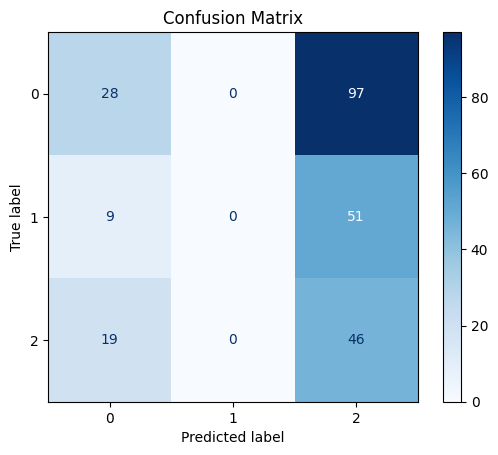

In [73]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix using Matplotlib
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


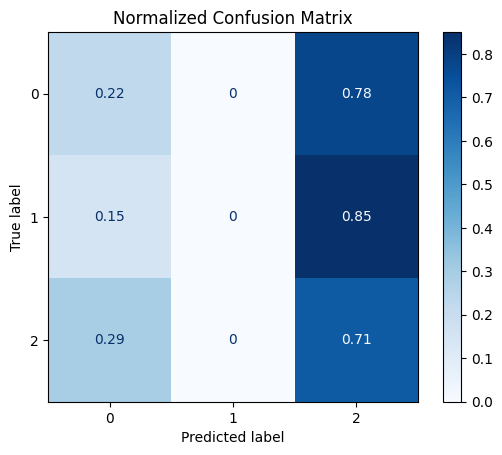

In [74]:
# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=range(len(cm)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.show()

In [59]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy from the history.

    :param history: Dictionary containing 'train_loss', 'train_acc', 'val_loss', and 'val_acc'.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_training_history(history)


NameError: name 'history' is not defined

In [163]:
history['train_loss']

[0.6888625067472458,
 0.32871470890939236,
 0.22974944168080885,
 0.19101758663232127,
 0.1422079183254391,
 0.15438521528926988,
 0.15233192963312225,
 0.11593809588715279,
 0.14260468310807484,
 0.16523481479933252]

In [62]:
# Assuming 'model' is your original model definition
best_model_path = '/content/best_model.pth'

# Load the saved best model weights
restNet50_model.load_state_dict(torch.load(best_model_path))

# Ensure the model is in evaluation mode
restNet50_model.eval()

# Print the model architecture
print("Best Model Architecture:")
print(restNet50_model)

# Optional: Print all parameters
print("\nModel Parameters:")
for name, param in restNet50_model.named_parameters():
    print(f"{name}: {param.size()}")


Best Model Architecture:
ResNet50Classifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
     

In [63]:
restNet50_model.load_state_dict(torch.load('best_model.pth'))
restNet50_model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloader_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = restNet50_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(dataloader_test)
test_acc = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


Test Loss: 1.0866, Test Accuracy: 29.60%


### Testing Model Phase

In [177]:
import os
from datetime import datetime

file_path = '/content/best_model.pth'

# Get the last modification time
mod_time = os.path.getmtime(file_path)

# Convert to a human-readable format
mod_time_readable = datetime.fromtimestamp(mod_time)
print(f"The file '{file_path}' was last modified on: {mod_time_readable}")


The file '/content/best_model.pth' was last modified on: 2024-12-09 23:19:26.321609


In [178]:
import torch

# Define the model (should match the architecture used during training)
model = restNet50_model # Replace with your model class
model.load_state_dict(torch.load('best_model2.pth'))
model.eval()

# Evaluate on validation or test dataset
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloader_val:  # Use your validation/test DataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

val_loss /= len(dataloader_val)
val_acc = 100. * correct / total

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")


Validation Loss: 0.0044, Validation Accuracy: 100.00%
